In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'potato disease',
    shuffle = True,
    batch_size = BATCH_SIZE,
    image_size = (IMAGE_SIZE, IMAGE_SIZE)
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Early_blight', 'Late_blight', 'healthy']

In [5]:
len(dataset)

68

In [7]:
2152/32

67.25

In [8]:
for image_batch, label_batch in dataset.take(1): # taking the first batch containing 32 random_pics
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1]


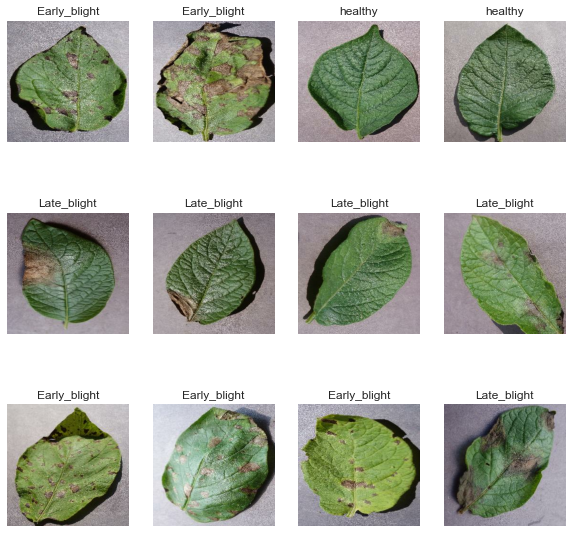

In [10]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1) #  placing the position of the newest image in 3*4 gric
        plt.axis('off')
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])

# creating training and testing validation_dataset

In [11]:
def train_test_val(ds, train_split=0.8, val_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = train_test_val(dataset)

In [13]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [15]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [16]:
img_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu',
                  input_shape=img_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 2), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 2), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])


model.build(input_shape=img_shape)

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (32, 256, 256, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (32, 128, 128, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (32, 128, 128, 64)        12352     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (32, 64, 64, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (32, 64, 64, 64)         

In [18]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [19]:
history = model.fit(train_ds, batch_size=32, epochs=15, validation_data=val_ds, verbose=1)

Epoch 1/15
54/54 [==============================] - 88s 2s/step - loss: 0.8453 - accuracy: 0.6898 - val_loss: 0.4852 - val_accuracy: 0.8333
Epoch 2/15
54/54 [==============================] - 84s 2s/step - loss: 0.3980 - accuracy: 0.8623 - val_loss: 0.3244 - val_accuracy: 0.8958
Epoch 3/15
54/54 [==============================] - 78s 1s/step - loss: 0.3004 - accuracy: 0.8738 - val_loss: 0.2159 - val_accuracy: 0.8958
Epoch 4/15
54/54 [==============================] - 81s 1s/step - loss: 0.2076 - accuracy: 0.8981 - val_loss: 0.2228 - val_accuracy: 0.9427
Epoch 5/15
54/54 [==============================] - 81s 2s/step - loss: 0.2125 - accuracy: 0.9271 - val_loss: 0.2211 - val_accuracy: 0.9115
Epoch 6/15
54/54 [==============================] - 86s 2s/step - loss: 0.1441 - accuracy: 0.9462 - val_loss: 0.1185 - val_accuracy: 0.9688
Epoch 7/15
54/54 [==============================] - 82s 2s/step - loss: 0.1209 - accuracy: 0.9572 - val_loss: 0.1633 - val_accuracy: 0.9427
Epoch 8/15
54/54 [==

In [20]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 345ms/step - loss: 0.1153 - accuracy: 0.9648


[0.11528421938419342, 0.96484375]

<h1>We got a accuracy of 96% which is pretty good</h1>

In [43]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

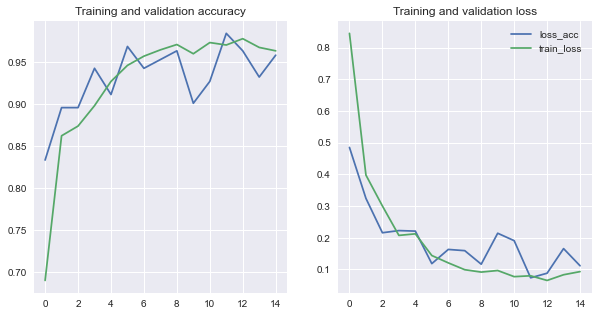

In [61]:
plt.style.use('seaborn')
plt.figure(figsize=(10, 5))

val_acc = history.history['val_accuracy']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
train_loss = history.history['loss']

epochs = range(15)

plt.subplot(1, 2, 1)
plt.plot(epochs, val_acc, label='val_acc')
plt.plot(epochs, train_acc, label='train_acc')
plt.title('Training and validation accuracy')


plt.subplot(1, 2, 2)
plt.plot(epochs, val_loss, label='loss_acc')
plt.plot(epochs, train_loss, label='train_loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

<h2>Prediction</h2>

In [33]:
class_names

['Early_blight', 'Late_blight', 'healthy']

In [75]:
# lets create a function which will take in a image and return it's label and confidence of prediction

def get_prediction(model, image, classes):
    batch_img = image.numpy()
    batch_img = np.expand_dims(batch_img, axis=0)
    
    predictions = model.predict(batch_img)
    pred_label = classes[np.argmax(predictions)]
    
    probability = np.max(predictions)
    confidence = round(probability * 100, 2)
    
    return pred_label, confidence

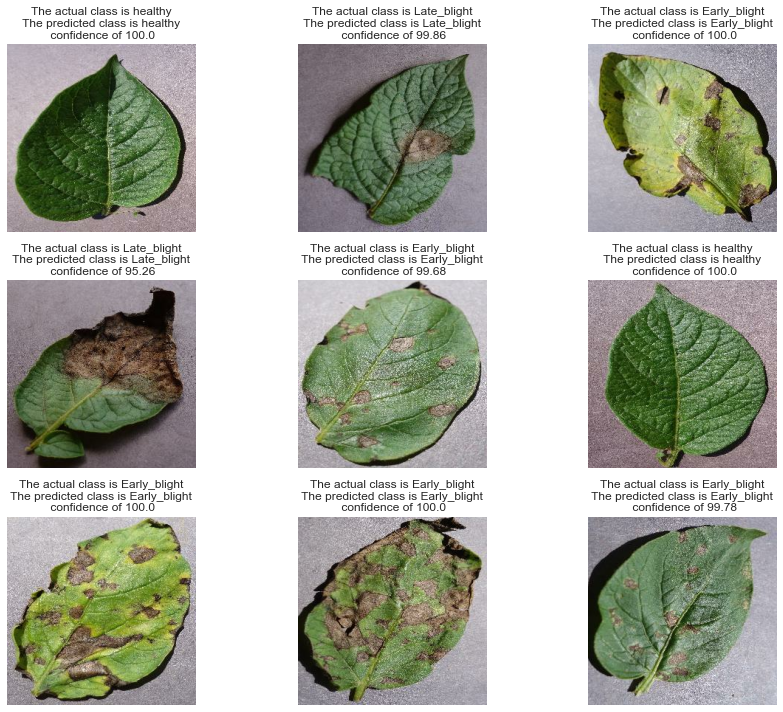

In [95]:
plt.figure(figsize=(13, 10))
for image_batch, image_label in test_ds.take(1):
    for i in range(9):
        img = image_batch[i].numpy().astype('uint8')
        
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        
        pred_label, confidence = get_prediction(model, image_batch[i], class_names)
        true_label = class_names[image_label[i].numpy()]
        
        plt.title(f'The actual class is {true_label}\n The predicted class is {pred_label} \n confidence of {confidence}')
        
        plt.axis('off')
        
plt.tight_layout()

In [31]:
import os 

[int(version) for version in os.listdir('../models')] + [0]

[0]

In [35]:
model_version = max([int(version) for version in os.listdir('../models')] + [0]) + 1

model.save(f'../models/{model_version}') 
# goes backward one directory from the current one which is specified with ./

INFO:tensorflow:Assets written to: ../models/1\assets


<h1>LETS CREATE A VERSION 2 MODEL HOPING TO IMPROVE THE ACCURACY</h1>

In [22]:
img_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model2 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=img_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    
    layers.Flatten(),
    
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='sigmoid')
])


model2.build(input_shape=img_shape)

In [23]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (32, 127, 127, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (32, 63, 63, 64)          0         
_________________________________________________________________
conv2d_13 (Conv2D)           (32, 63, 63, 64)         

In [24]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [25]:
history = model2.fit(train_ds, batch_size=32, epochs=15, validation_data=val_ds, verbose=1)

Epoch 1/15
54/54 [==============================] - 121s 2s/step - loss: 0.7856 - accuracy: 0.6065 - val_loss: 0.4036 - val_accuracy: 0.8542
Epoch 2/15
54/54 [==============================] - 107s 2s/step - loss: 0.3665 - accuracy: 0.8640 - val_loss: 0.3191 - val_accuracy: 0.8802
Epoch 3/15
54/54 [==============================] - 100s 2s/step - loss: 0.3314 - accuracy: 0.8646 - val_loss: 0.2702 - val_accuracy: 0.8958
Epoch 4/15
54/54 [==============================] - 96s 2s/step - loss: 0.2664 - accuracy: 0.9097 - val_loss: 0.1431 - val_accuracy: 0.9792
Epoch 5/15
54/54 [==============================] - 96s 2s/step - loss: 0.1928 - accuracy: 0.9230 - val_loss: 0.1662 - val_accuracy: 0.9375
Epoch 6/15
54/54 [==============================] - 98s 2s/step - loss: 0.0993 - accuracy: 0.9630 - val_loss: 0.0991 - val_accuracy: 0.9635
Epoch 7/15
54/54 [==============================] - 101s 2s/step - loss: 0.1250 - accuracy: 0.9543 - val_loss: 0.3534 - val_accuracy: 0.8490
Epoch 8/15
54/54

In [28]:
model2.evaluate(test_ds)

8/8 [==============================] - 5s 442ms/step - loss: 0.0671 - accuracy: 0.9805


[0.06705426424741745, 0.98046875]

<h2>THERE WAS AN INCREASE IN ACCURACY</h2>

In [36]:
model_version = max([int(version) for version in os.listdir('../models')] + [0]) + 1

model2.save(f'../models/{model_version}') 

INFO:tensorflow:Assets written to: ../models/2\assets
